In [330]:
import pandas as pd
import numpy as np
from hierarchicalforecast.utils import aggregate
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp
import matplotlib.pyplot as plt

In [331]:
# Configuración inicial
BANCOS = [40002, 40012, 40014, 40021, 40072]
CREDITO_ROOT = 40100185
CONCEPTOS_RANGO = (CREDITO_ROOT, 40100223)

In [333]:
def cargar_datos():
    """Carga y filtra datos optimizando tipos de datos"""
    dtypes_conceptos = {
        'idtema': 'int8', 'idconcepto': 'int32', 'nivel': 'int8', 
        'indicador': 'int8', 'orden': 'int16'
    }
    
    df_conceptos = pd.read_csv(
        './data/cat_conceptos_40.csv', 
        encoding='latin1',
        dtype=dtypes_conceptos
    ).query(f'idconcepto >= {CONCEPTOS_RANGO[0]} & idconcepto <= {CONCEPTOS_RANGO[1]}')
    
    dtypes_data = {
        'sector': 'int8', 'idconcepto': 'int32', 'entidad': 'int32',
        'periodo': 'int32', 'saldo': 'float32', 'valor': 'float32'
    }
    
    df_data = pd.read_csv(
        './data/sh_datos_40.csv', 
        encoding='latin1',
        dtype=dtypes_data
    ).query(f'entidad in {BANCOS} & idconcepto >= {CONCEPTOS_RANGO[0]} & idconcepto <= {CONCEPTOS_RANGO[1]}')
    
    return df_conceptos, df_data

# 1. Carga y preparación de datos
df_conceptos, df_data = cargar_datos()

In [335]:
def construir_jerarquia(df_conceptos):
    """Construye la jerarquía optimizada con operaciones vectorizadas"""
    df_sorted = df_conceptos.sort_values('orden')
    niveles = df_sorted['nivel'].values
    conceptos = df_sorted['idconcepto'].values
    
    hierarchy = []
    last_parents = {}
    
    for i, (nivel, concepto) in enumerate(zip(niveles, conceptos)):
        if nivel > 3:
            parent_nivel = nivel - 1
            parent = last_parents.get(parent_nivel)
            if parent:
                hierarchy.append((concepto, parent))
        last_parents[nivel] = concepto
        
    return hierarchy, dict(zip(conceptos, niveles))

# 2. Construcción de jerarquía
hierarchy, level_map = construir_jerarquia(df_conceptos)

In [347]:
#########################################
# Construir la cadena de ancestros dinámicamente
#########################################

def get_ancestor_chain_dynamic(leaf, parent_dict, level_map, base_level=3):
    """
    Devuelve un diccionario con la cadena de ancestros desde base_level hasta el nivel del nodo hoja.
    Ejemplo: si un nodo hoja tiene nivel 5, se devolverá:
      {'level3': <id del ancestro en level3>,
       'level4': <id del ancestro en level4>,
       'level5': <id del nodo hoja>}
    """
    chain = {}
    current = leaf
    while True:
        lvl = level_map.get(current, None)
        if lvl is None or lvl < base_level:
            break
        chain[f'level{lvl}'] = current
        if current not in parent_dict:
            break
        current = parent_dict[current]
    # Reordenar las claves en orden ascendente (level3, level4, ..., levelN)
    sorted_keys = sorted(chain.keys(), key=lambda x: int(x.replace('level','')))
    chain_sorted = {k: chain[k] for k in sorted_keys}
    return chain_sorted

In [354]:
def get_ancestor_chain_dynamic(leaf, parent_dict, level_map, base_level=3):
    """
    Devuelve un diccionario con la cadena de ancestros desde base_level hasta el nivel del nodo hoja.
    Por ejemplo, si un nodo hoja tiene nivel 5, se devolverá:
      {'level3': <id del ancestro en level3>,
       'level4': <id del ancestro en level4>,
       'level5': <id del nodo hoja>}
    Se asume que la cadena es continua en la jerarquía.
    """
    chain = {}
    current = leaf
    while True:
        lvl = level_map.get(current, None)
        if lvl is None or lvl < base_level:
            break
        chain[f'level{lvl}'] = current
        if current not in parent_dict:
            break
        current = parent_dict[current]
    # Ordenar la cadena de forma ascendente (level3, level4, ..., levelN)
    sorted_keys = sorted(chain.keys(), key=lambda x: int(x.replace('level', '')))
    chain_sorted = {k: chain[k] for k in sorted_keys}
    return chain_sorted

def procesar_datos(df_data, hierarchy, level_map):
    """Procesamiento optimizado de datos con tipos categóricos"""
    # Filtrar nodos hoja
    padres = {p for _, p in hierarchy}
    hojas = [c for c in level_map if c not in padres]
    
    # Construir estructura jerárquica
    niveles = sorted({v for v in level_map.values() if v >= 3})
    spec = [['entidad'] + [f'level{l}' for l in range(3, lvl+1)] for lvl in niveles]

    # Paso 1: Procesar df_data y crear columnas ds y unique_id
    df_proc = (
        df_data[df_data['idconcepto'].isin(hojas)]
        .assign(
            ds=lambda x: pd.to_datetime(x['periodo'], format='%Y%m'),
            unique_id=lambda x: x['entidad'].astype(str) + '_' + x['idconcepto'].astype(str)
        )
    )
    
    # Paso 2: Crear DataFrame con la cadena de ancestros para cada hoja
    df_chain = pd.DataFrame([
        {**get_ancestor_chain_dynamic(c, parent_dict, level_map, base_level=3), 'idconcepto': c}
        for c in hojas
    ]).fillna(0)
    
    # Paso 3: Merge para incorporar la cadena de ancestros a df_proc
    df_procesado = df_proc.merge(df_chain, on='idconcepto', how='inner')
    
    # Paso 4: Renombrar 'valor' a 'y' y seleccionar las columnas deseadas
    df_procesado = df_procesado.rename(columns={'valor': 'y'})
    df_procesado = df_procesado[['entidad', 'ds', 'y'] + [f'level{l}' for l in niveles]]

    return aggregate(df_procesado, spec=spec)

# 3. Procesamiento de datos
Y_hier_df, S_df, tags = procesar_datos(df_data, hierarchy, level_map)

In [359]:
def pronosticar_y_reconciliar(Y_hier_df):
    """Ejecuta el pipeline de pronóstico optimizado"""
    # Preparar datos
    df_train = Y_hier_df[['unique_id', 'ds', 'y']].astype({
        'unique_id': 'category', 
        'ds': 'datetime64[ns]',
        'y': 'float32'
    })
    
    # Modelado paralelizado
    sf = StatsForecast(
        models=[AutoARIMA(season_length=12)],
        freq='ME',
        n_jobs=-1
    )
    sf.fit(df_train)
    
    # Pronóstico y reconciliación
    forecast = sf.predict(h=30)
    reconciler = HierarchicalReconciliation(reconcilers=[BottomUp()])
    reconciled = reconciler.reconcile(
        Y_hat_df=forecast,
        Y_df=df_train,
        S=S_df,
        tags=tags
    )
    
    return forecast, reconciled

# 4. Pronóstico y reconciliación
forecast, participacion = pronosticar_y_reconciliar(Y_hier_df)

In [361]:
def calcular_participacion(reconciled):
    """Cálculo vectorizado de participación de mercado"""
    # Convertir a estructura wide para cálculo eficiente
    df_wide = (
        reconciled.set_index(['ds', 'unique_id'])['AutoARIMA/BottomUp']
        .unstack()
        .astype('float32')
    )
    
    total_sistema = df_wide.sum(axis=1)
    participacion = df_wide.div(total_sistema, axis=0)
    
    return participacion

# 5. Cálculo de participación
participacion = calcular_participacion(reconciled)

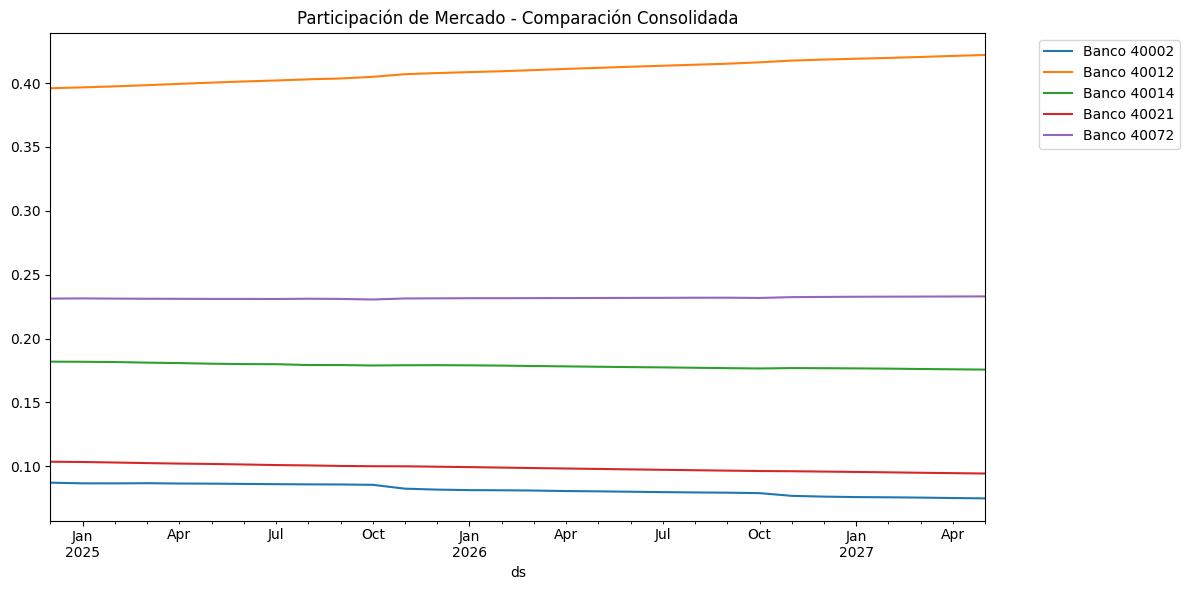

In [364]:
def visualizar_resultados(participacion):
    """Visualización optimizada"""
    plt.figure(figsize=(12, 6))
    for banco in BANCOS:
        mask = participacion.columns.str.startswith(f"{banco}/")
        datos = participacion.loc[:, mask].sum(axis=1)
        datos.plot(label=f'Banco {banco}')
    
    plt.title('Participación de Mercado - Comparación Consolidada')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 6. Visualización
visualizar_resultados(participacion)